# Import thư viện cần thiết

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu từ file `data/movies_dataset_revenue.csv`

In [7]:
DATA_PATH = "../data/movies_dataset_revenue.csv"

df = pd.read_csv(DATA_PATH)
print("Shape of the dataset:", df.shape)

Shape of the dataset: (11187, 17)


# Chuẩn hóa biến mục tiêu `revenue`

In [8]:
df['revenue'] = np.log1p(df['revenue'])

# Phân phối của Doanh thu (`revenue`) sau khi chuẩn hóa Log

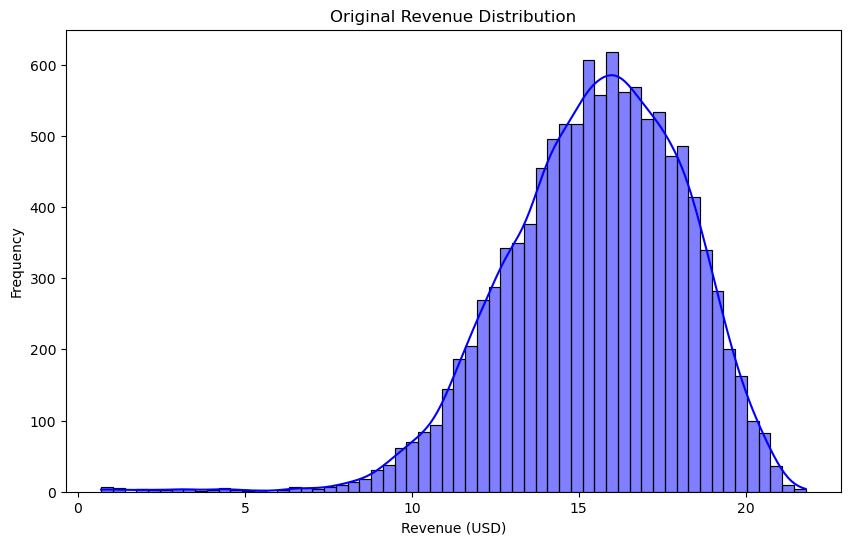

In [9]:
# Visualize revenue distribution after log transformation
plt.figure(figsize=(10, 6))
sns.histplot(df['revenue'], bins=60, color='blue', kde=True)
plt.title('Original Revenue Distribution')
plt.xlabel('Revenue (USD)')
plt.ylabel('Frequency')
plt.show()

# Điền `Unknown` vào các giá trị `NaN` trong các cột `production_countries`, `production_companies`, `cast`, `director` và `keywords`.

In [10]:
df['production_companies'] = df['production_companies'].fillna('unknown')
df['production_companies'] = df['production_companies'].fillna('unknown')
df['cast'] = df['cast'].fillna('unknown')
df['director'] = df['director'].fillna('unknown')
df['keywords'] = df['keywords'].fillna('unknown')

# Chuyển cột `release_date` thành kiểu **datetime** và từ đó trích xuất ra các cột cụ thể như là `release_month`, `release_year`, `release_dayofweek`, `release_quarter`, ... giúp mô hình học tốt hơn.

In [11]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['release_dayofweek'] = df['release_date'].dt.dayofweek
df['release_quarter'] = df['release_date'].dt.quarter
# Create a feature for weekend releases
df['is_weekend'] = df['release_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
# Create a feature for blockbuster seasons
df['is_blockbuster_season'] = df['release_month'].apply(lambda x: 1 if x in [5, 6, 7, 11, 12] else 0)

# Biến cột `collection` thành cột `is_franchise` tương ứng nếu là giá trị **NaN** điền `0` (phim chỉ có 1 phần) và điền `1` (nếu nhiều phần).

In [12]:
df['is_franchise'] = df['collection'].notna().astype(int)

# Biến đổi các cột có nhiều giá trị ngăn cách nhau bằng dấu phẩy `,` thành dạng `List`

In [13]:
list_cols = ['genres', 'cast', 'production_companies', 'production_countries', 'director', 'keywords']

# Function to safely parse list-like strings
def parse_list_safe(x):
    if pd.isna(x) or x == "" or str(x).strip() == "":
        return []
    if isinstance(x, str):
        return [i.strip() for i in x.split(',')]
    return []

for col in list_cols:
    df[col] = df[col].apply(parse_list_safe)

# Xử lý outliers

In [14]:
outlier_indices = []
for col in ['budget', 'revenue', 'runtime', 'rating', 'vote_count', 'popularity']:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
        outlier_indices.extend(outliers)
        
        print(f"  - {col}: {len(outliers)} outliers (Range: [{lower_bound:.2f}, {upper_bound:.2f}])")

# Xóa outliers (tối đa 5% dữ liệu)
unique_outlier_indices = list(set(outlier_indices))
max_outliers_to_remove = int(len(df) * 0.05)

if len(unique_outlier_indices) > max_outliers_to_remove:
    print(f"\n⚠️ Số outliers vượt quá 5%, chỉ xóa {max_outliers_to_remove} outliers")
    unique_outlier_indices = unique_outlier_indices[:max_outliers_to_remove]
else:
    print(f"\nXóa {len(unique_outlier_indices)} outliers")
    df = df.drop(unique_outlier_indices)

print(f"Sau khi xử lý outliers: {len(df)} phim")

  - budget: 1160 outliers (Range: [-30000000.00, 50000000.00])
  - revenue: 92 outliers (Range: [8.42, 22.84])
  - runtime: 443 outliers (Range: [58.00, 154.00])
  - rating: 170 outliers (Range: [4.06, 8.71])
  - vote_count: 1429 outliers (Range: [-1607.00, 2857.00])
  - popularity: 469 outliers (Range: [-3.00, 9.75])

⚠️ Số outliers vượt quá 5%, chỉ xóa 559 outliers
Sau khi xử lý outliers: 11187 phim


# Chia dữ liệu thành tập train và test để tránh việc mô hình "nhìn" trước đáp án

In [15]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Xử lí các cột `runtime` và cột `budget`: 

- Điền `runtime` bị thiếu bằng median của cột `runtime`.

- Điền `budget` bằng giá trị trung vị `budget` của các phim cùng thể loại và trong cùng năm. Sau đó sử dụng **Log Transformation** để chuẩn hóa.

In [16]:
# runtime
train['runtime'] = train['runtime'].replace(0, np.nan)
train['runtime'] = train['runtime'].fillna(train['runtime'].median())
test['runtime'] = test['runtime'].replace(0, np.nan)
test['runtime'] = test['runtime'].fillna(train['runtime'].median())

# handle missing budget values
train['budget'] = train['budget'].replace(0, np.nan)
train['temp_genre'] = train['genres'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')
budget_train_medians = train.groupby(['release_year', 'temp_genre'])['budget'].transform('median')
train['budget'] = train['budget'].fillna(budget_train_medians).fillna(train['budget'].median())

test['budget'] = test['budget'].replace(0, np.nan)
test['temp_genre'] = test['genres'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')
budget_test_medians = test.groupby(['release_year', 'temp_genre'])['budget'].transform('median')
test['budget'] = test['budget'].fillna(budget_test_medians).fillna(train['budget'].median())

# drop temp columns
train.drop(columns=['temp_genre'], inplace=True)
test.drop(columns=['temp_genre'], inplace=True)

# log-transform revenue
train['budget'] = np.log1p(train['budget'])
test['budget'] = np.log1p(test['budget'])

# Phân phối của `runtime` và `budget` sau khi xử lí

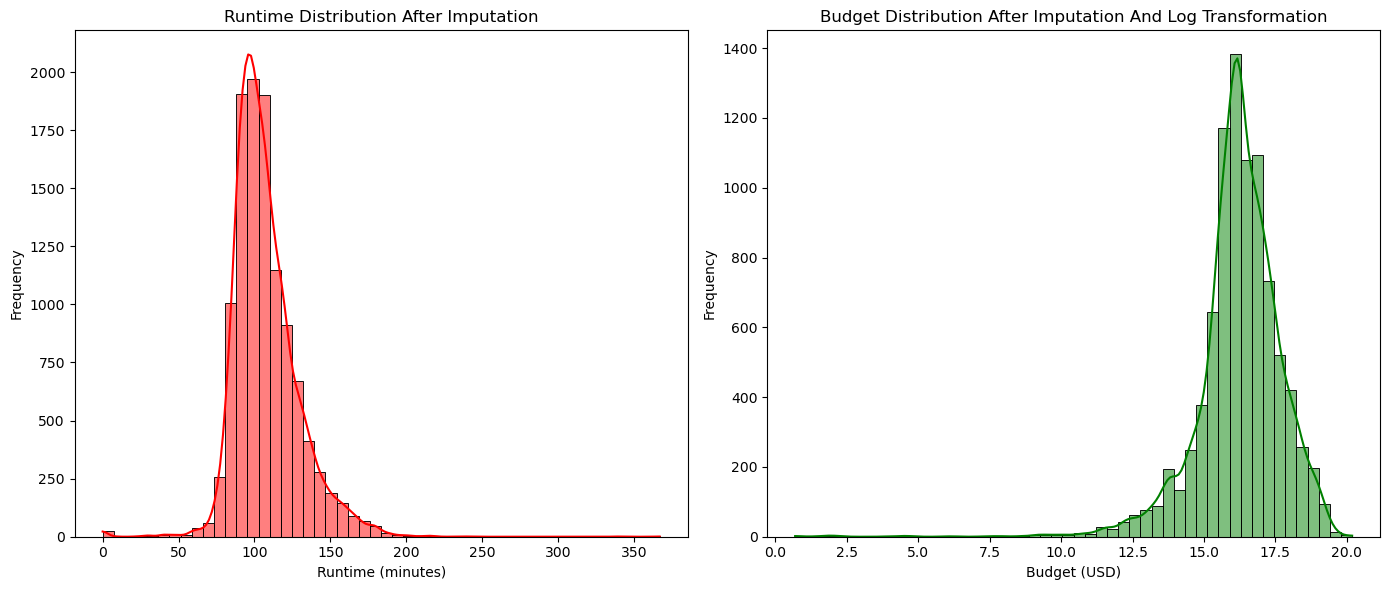

In [17]:
plt.figure(figsize=(14, 6))
# visualize runtime distribution
plt.subplot(1, 2, 1)
sns.histplot(df['runtime'], bins=50, color='red', kde=True)
plt.title('Runtime Distribution After Imputation')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')

# visualize budget distribution
plt.subplot(1, 2, 2)
sns.histplot(train['budget'], bins=50, color='green', kde=True)
plt.title('Budget Distribution After Imputation And Log Transformation')
plt.xlabel('Budget (USD)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Kiểm tra lại mối quan hệ giữa `budget` và `revenue` sau khi xử lí.

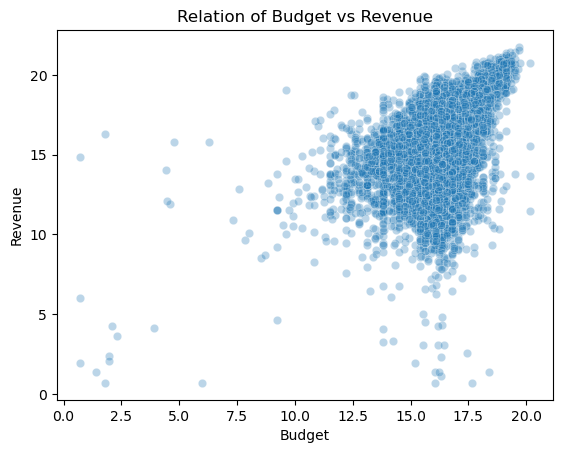

In [18]:
sns.scatterplot(data=train, x='budget', y='revenue', alpha=0.3)
plt.title('Relation of Budget vs Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()

# Tạo các đặc trưng mới của các cột `cast`, `director`, `genres`, ... dựa trên doanh thu của chúng trong quá khứ.

In [19]:
def time_based_target_encoding(df, list_col_name, target_col, alpha=10):
    """
    Tính encoding dựa trên lịch sử quá khứ.
    - df: DataFrame ĐÃ ĐƯỢC SORT theo thời gian.
    - list_col_name: Cột chứa list (vd: cast, keywords).
    - target_col: Cột mục tiêu (log_revenue).
    - alpha: Hệ số làm mượt (smoothing factor).
    """
    global_mean = df[target_col].mean()
    
    # Dictionary lưu lịch sử: {'Tom Cruise': {'sum': 500, 'count': 5}}
    history = {}
    
    feature_values = []
    
    # Duyệt tuần tự theo thời gian
    for idx, row in df.iterrows():
        # Parse chuỗi "Tom, Jerry" thành list ['Tom', 'Jerry']
        current_items = row[list_col_name]

        target_val = row[target_col]
        
        # DỰ ĐOÁN (Dựa trên quá khứ)
        stats = []
        for item in current_items:
            if item in history:
                rec = history[item]
                # Smoothed Mean: (Tổng doanh thu quá khứ + alpha * Global) / (Số phim quá khứ + alpha)
                mean_val = (rec['sum'] + alpha * global_mean) / (rec['count'] + alpha)
                stats.append(mean_val)
            else:
                stats.append(global_mean)
        
        # Tổng hợp điểm số cho bộ phim
        if stats:
            # Kết hợp: 70% sức mạnh ngôi sao lớn nhất (Max) + 30% sức mạnh tập thể (Mean)
            score = 0.7 * np.max(stats) + 0.3 * np.mean(stats)
        else:
            score = global_mean
            
        feature_values.append(score)
        
        #  (Cập nhật vào lịch sử cho phim sau dùng)
        if target_val > 0: 
            for item in current_items:
                if item not in history:
                    history[item] = {'sum': 0.0, 'count': 0.0}
                history[item]['sum'] += target_val
                history[item]['count'] += 1.0
            
    return feature_values

train = train.sort_values('release_date').reset_index(drop=True)
test = test.sort_values('release_date').reset_index(drop=True)

# 1. Cast 
train['cast_score'] = time_based_target_encoding(train, 'cast', 'revenue', alpha=10)
test['cast_score'] = time_based_target_encoding(test, 'cast', 'revenue', alpha=10)

# 2. Director
train['director_score'] = time_based_target_encoding(train, 'director', 'revenue', alpha=5)
test['director_score'] = time_based_target_encoding(test, 'director', 'revenue', alpha=5)

# 3. Keywords
train['keyword_score'] = time_based_target_encoding(train, 'keywords', 'revenue', alpha=20)
test['keyword_score'] = time_based_target_encoding(test, 'keywords', 'revenue', alpha=20)

# 4. Genres
train['genre_score'] = time_based_target_encoding(train, 'genres', 'revenue', alpha=50)
test['genre_score'] = time_based_target_encoding(test, 'genres', 'revenue', alpha=50)

# 5. Production Companies 
train['production_company_score'] = time_based_target_encoding(train, 'production_companies', 'revenue', alpha=10)
test['production_company_score'] = time_based_target_encoding(test, 'production_companies', 'revenue', alpha=10)

# 6. Production Countries
train['country_score'] = time_based_target_encoding(train, 'production_countries', 'revenue', alpha=20)
test['country_score'] = time_based_target_encoding(test, 'production_countries', 'revenue', alpha=20)

# 7. collection
def parse_collection_to_list(x):
    if pd.isna(x) or x == "" or str(x).strip() == "":
        return []
    return [str(x).strip()]

train['collection_list'] = train['collection'].apply(parse_collection_to_list)
train['collection_score'] = time_based_target_encoding(train, 'collection_list', 'revenue', alpha=1)
test['collection_list'] = test['collection'].apply(parse_collection_to_list)
test['collection_score'] = time_based_target_encoding(test, 'collection_list', 'revenue', alpha=1)

# MLB cho Genres
mlb = MultiLabelBinarizer()
genres_encoded_train = mlb.fit_transform(train['genres'])
genres_encoded_test = mlb.transform(test['genres'])
genres_df_train = pd.DataFrame(genres_encoded_train, columns=[f"genre_{c.replace(' ','_')}" for c in mlb.classes_], index=train.index)
train = train.join(genres_df_train)
genres_df_test = pd.DataFrame(genres_encoded_test, columns=[f"genre_{c.replace(' ','_')}" for c in mlb.classes_], index=test.index)
test = test.join(genres_df_test)


cols_to_drop = ['title', 'release_date', 'genres', 'cast', 'production_companies', 
                'production_countries', 'keywords', 'director', 'original_language', 'rating',
                'vote_count', 'popularity', 'collection_list', 'collection']
cols_to_drop = [c for c in cols_to_drop if c in train.columns]
    
train_final = train.drop(columns=cols_to_drop)
test_final = test.drop(columns=cols_to_drop)
train_final.columns

Index(['id', 'budget', 'revenue', 'runtime', 'release_year', 'release_month',
       'release_dayofweek', 'release_quarter', 'is_weekend',
       'is_blockbuster_season', 'is_franchise', 'cast_score', 'director_score',
       'keyword_score', 'genre_score', 'production_company_score',
       'country_score', 'collection_score', 'genre_Action', 'genre_Adventure',
       'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary',
       'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History',
       'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance',
       'genre_Science_Fiction', 'genre_TV_Movie', 'genre_Thriller',
       'genre_War', 'genre_Western'],
      dtype='object')

# Hàm pipeline encoding

In [20]:
def pipeline_encoding(df):
    # Log-transform revenue
    df['revenue'] = np.log1p(df['revenue'])

    # release date features
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_dayofweek'] = df['release_date'].dt.dayofweek
    df['release_quarter'] = df['release_date'].dt.quarter
    # Create a feature for weekend releases
    df['is_weekend'] = df['release_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    # Create a feature for blockbuster seasons
    df['is_blockbuster_season'] = df['release_month'].apply(lambda x: 1 if x in [5, 6, 7, 11, 12] else 0)
    
    # Function to safely parse list-like strings
    list_cols = ['genres', 'cast', 'production_companies', 'production_countries', 'director', 'keywords']
    def parse_list_safe(x):
        if pd.isna(x) or x == "" or str(x).strip() == "":
            return []
        if isinstance(x, str):
            return [i.strip() for i in x.split(',')]
        return []
    # convert list-like columns
    for col in list_cols:
        df[col] = df[col].apply(parse_list_safe)
        
    # collection feature
    df['is_franchise'] = df['collection'].notna().astype(int)

    # runtime
    df['runtime'] = df['runtime'].replace(0, np.nan)
    df['runtime'] = df['runtime'].fillna(df['runtime'].median())

    # handle missing budget values
    df['budget'] = df['budget'].replace(0, np.nan)
    df['temp_genre'] = df['genres'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')

    budget_medians = df.groupby(['release_year', 'temp_genre'])['budget'].transform('median')
    df['budget'] = df['budget'].fillna(budget_medians).fillna(df['budget'].median())

    # drop temp columns
    df.drop(columns=['temp_genre'], inplace=True)
    # log-transform revenue
    df['budget'] = np.log1p(df['budget'])
    
    def time_based_target_encoding(df, list_col_name, target_col, alpha=10):
        """
        Tính encoding dựa trên lịch sử quá khứ.
        - df: DataFrame ĐÃ ĐƯỢC SORT theo thời gian.
        - list_col_name: Cột chứa list (vd: cast, keywords).
        - target_col: Cột mục tiêu (log_revenue).
        - alpha: Hệ số làm mượt (smoothing factor).
        """
        global_mean = df[target_col].mean()
        
        # Dictionary lưu lịch sử: {'Tom Cruise': {'sum': 500, 'count': 5}}
        history = {}
        
        feature_values = []
        
        # Duyệt tuần tự theo thời gian
        for idx, row in df.iterrows():
            # Parse chuỗi "Tom, Jerry" thành list ['Tom', 'Jerry']
            current_items = row[list_col_name]

            target_val = row[target_col]
            
            # DỰ ĐOÁN (Dựa trên quá khứ)
            stats = []
            for item in current_items:
                if item in history:
                    rec = history[item]
                    # Smoothed Mean: (Tổng doanh thu quá khứ + alpha * Global) / (Số phim quá khứ + alpha)
                    mean_val = (rec['sum'] + alpha * global_mean) / (rec['count'] + alpha)
                    stats.append(mean_val)
                else:
                    stats.append(global_mean)
            
            # Tổng hợp điểm số cho bộ phim
            if stats:
                # Kết hợp: 70% sức mạnh ngôi sao lớn nhất (Max) + 30% sức mạnh tập thể (Mean)
                score = 0.7 * np.max(stats) + 0.3 * np.mean(stats)
            else:
                score = global_mean
                
            feature_values.append(score)
            
            #  (Cập nhật vào lịch sử cho phim sau dùng)
            if target_val > 0: 
                for item in current_items:
                    if item not in history:
                        history[item] = {'sum': 0.0, 'count': 0.0}
                    history[item]['sum'] += target_val
                    history[item]['count'] += 1.0
        return feature_values

    df = df.sort_values('release_date').reset_index(drop=True)

    # 1. Cast
    df['cast_score'] = time_based_target_encoding(df, 'cast', 'revenue', alpha=10)

    # 2. Director
    df['director_score'] = time_based_target_encoding(df, 'director', 'revenue', alpha=5)

    # 3. Keywords
    df['keyword_score'] = time_based_target_encoding(df, 'keywords', 'revenue', alpha=20)

    # 4. Genres
    df['genre_score'] = time_based_target_encoding(df, 'genres', 'revenue', alpha=50)

    # 5. Production Companies 
    df['production_company_score'] = time_based_target_encoding(df, 'production_companies', 'revenue', alpha=10)

    # 6. Production Countries
    df['country_score'] = time_based_target_encoding(df, 'production_countries', 'revenue', alpha=20)

    # 7. collection
    def parse_collection_to_list(x):
        if pd.isna(x) or x == "" or str(x).strip() == "":
            return []
        return [str(x).strip()]

    df['collection_list'] = df['collection'].apply(parse_collection_to_list)
    df['collection_score'] = time_based_target_encoding(df, 'collection_list', 'revenue', alpha=1)

    # MLB cho Genres
    mlb = MultiLabelBinarizer()
    genres_encoded = mlb.fit_transform(df['genres'])
    genres_df = pd.DataFrame(genres_encoded, columns=[f"genre_{c.replace(' ','_')}" for c in mlb.classes_], index=df.index)
    df = df.join(genres_df)

    cols_to_drop = ['title', 'release_date', 'genres', 'cast', 'production_companies', 
                    'production_countries', 'keywords', 'director', 'original_language', 'rating',
                    'vote_count', 'popularity', 'collection_list', 'collection']
    cols_to_drop = [c for c in cols_to_drop if c in df.columns]
    df_final = df.drop(columns=cols_to_drop)
    
    return df_final['revenue'], df_final.drop(columns='revenue')